*This notebook is revised based on the source:* [github](https://github.com/qojulia/QuantumOptics.jl-examples/tree/master/notebooks/jaynes-cummings.ipynb)

# Single-shot readout

## Driven Jaynes-Cummings model

The [Jaynes Cummings model](https://en.wikipedia.org/wiki/Jaynes%E2%80%93Cummings_model) is a famous theoretical model in the field of quantum optics. It describes a two level atom coupled to a quantized mode of a cavity. Here we would like to use it to model the qubit-resonator system, and further describe the quantum dynamics part of single-shot readout.

$H = \omega_r a^\dagger a + \frac{\omega_q}{2} \sigma_z + g (a \sigma_+ + a^\dagger \sigma_-)+ \sqrt{\kappa}A(t)(ia^{\dagger} e^{i\omega_{d}t} -i ae^{-i\omega_{d}t})$


The first step is always to import the library

In [1]:
using QuantumOptics
using PyPlot

Then we can define all the necessary parameters

In [2]:
# Parameters
N_cutoff = 15

ωr = 7.38 * 2π           # GHz
ωq = 6.245 * 2π          # GHz
ωd = (7.38-0.002) * 2π
g = 15 * 1e-3 * 2π       # GHz
η = -190 * 1e-3 * 2π     # GHz

T1 = 20 * 1e3            # Energy relexation constant: ns
Tphi = 2 * 1e3;          # pure dephasing constant   ns

κ = 1 * 1e-3              # resonator out: GHz
γ1 = 1/T1                 # energy relexation rate: GHz
γphi = 1/Tphi;            # pure dephasing rate: GHz

Describe the Fock Hilbert space and the Spin Hilbert space by choosing the appropriate bases

In [3]:
# Bases
b_fock = FockBasis(N_cutoff)
b_spin = SpinBasis(1//2)
b = b_fock ⊗ b_spin;

With the help of these bases build up the Jaynes-Cummings Hamiltonian

In [4]:
# Fundamental operators
a = destroy(b_fock)
at = create(b_fock)
n = number(b_fock)

sm = sigmam(b_spin)
sp = sigmap(b_spin)
sz = sigmaz(b_spin)

# Hamiltonian
Hatom = -ωq*sz/2
Hfield = ωr*n
Hint = g*(at⊗sm + a⊗sp)
H0 = one(b_fock)⊗Hatom + Hfield⊗one(b_spin) + Hint;

The time evolution of the system is governed by a Schroedinger equation.

In [5]:
# Initial state
α = 0.
Ψ0 = coherentstate(b_fock, α) ⊗ spindown(b_spin)

# Integration time
T = [0:0.625:600;]

function H_pump(t, psi)
    Hd = ( at⊗one(b_spin) ) *sqrt(κ)*1im*exp(-1im*ωd*t) - ( a⊗one(b_spin) )*sqrt(κ)*1im*exp(1im*ωd*t)
    return H0 + 10 * (t.>=0&&t.<=500) * Hd
end

# Schroedinger time evolution
tout, Ψt = timeevolution.schroedinger_dynamic(T, Ψ0, H_pump, 
                                                maxiters=1e8);

The integration routine returns two objects - a vector containing points of time where output was generated (which will in most cases be the same as the given input time vector) and a vector containing the state of the quantum system at these points in time. These can further on be used to calculate expectation values.

In [6]:
exp_n = real(expect(n ⊗ one(b_spin), Ψt))
exp_sz = real(expect(one(b_fock) ⊗ (sp*sm), Ψt));

Finally we can us [matplotlib](http://matplotlib.org/) to visualize the the time evolution of the calculated expectation values 

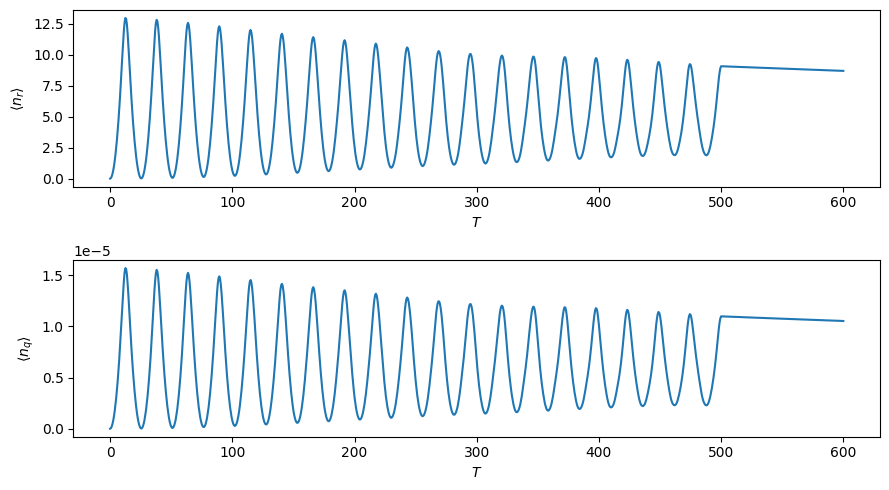

In [7]:
figure(figsize=(9,5))

subplot(2,1,1)
#ylim([0, 5])
plot(T, exp_n);
xlabel(L"T")
ylabel(L"\langle n_{r} \rangle")

subplot(2,1,2)
#ylim([-1, 1])
plot(T, exp_sz);
xlabel(L"T")
ylabel(L"\langle n_{q} \rangle")

tight_layout();

## Lossy Jaynes-Cummings model

The Jaynes-Cummings model can be expanded by giving the 2 level atom a finite spontenous decay rate $\gamma$. The system is then a open quantum system which is described by a master equation of the form

$$
    \dot{\rho} = -\frac{i}{\hbar} \big[H,\rho\big]
                 + \sum_i \big(
                        J_i \rho J_i^\dagger
                        - \frac{1}{2} J_i^\dagger J_i \rho
                        - \frac{1}{2} \rho J_i^\dagger J_i
                    \big)
$$

where in this case there is only one jump operator $J=\sqrt{\gamma} \sigma_-$.

In [8]:
R = [sqrt(κ), sqrt(γ1), sqrt(γphi/2)]
J = [a ⊗ identityoperator(b_spin),
     identityoperator(b_fock) ⊗ sm,
     identityoperator(b_fock) ⊗ sz];

Jdagger = dagger.(J);

In [9]:
function H_pump_open(t, psi)
    Hd = ( at⊗one(b_spin) ) *sqrt(κ)*1im*exp(-1im*ωr*t) - ( a⊗one(b_spin) )*sqrt(κ)*1im*exp(1im*ωr*t)
    return H0+40*(t>=0&&t<500)*Hd, J, Jdagger
end

# Master
tout, ρt = timeevolution.master_dynamic(T, Ψ0, H_pump_open; rates=R,
                                            maxiters=1e8)

exp_n_master = real(expect(n ⊗ one(b_spin), ρt))
exp_sz_master = real(expect(one(b_fock) ⊗ (sp*sm), ρt));

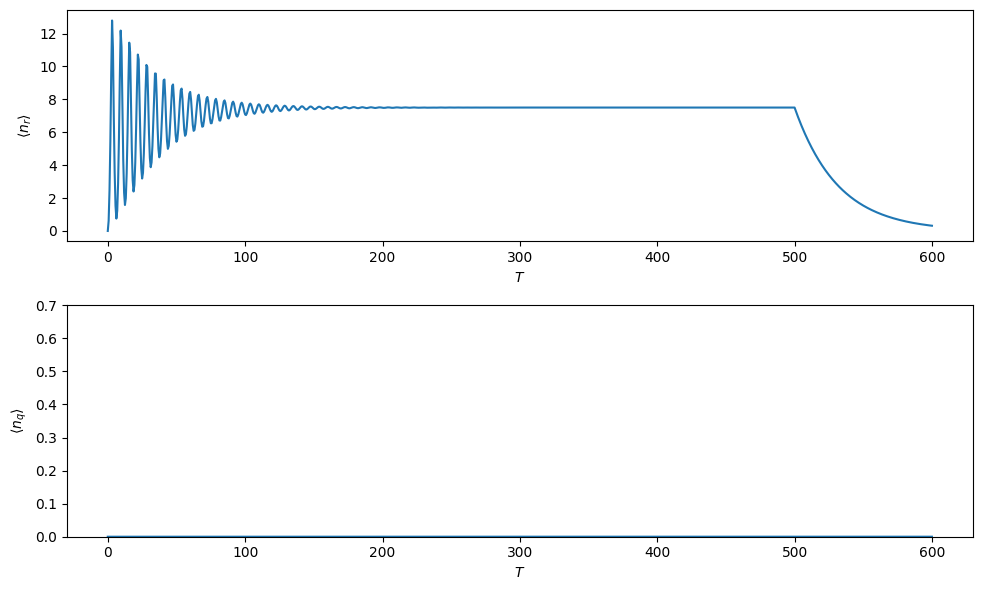

In [10]:
figure(figsize=(10,6))

subplot(2,1,1)
#ylim([0, 5])
plot(T, exp_n_master);
xlabel(L"T")
ylabel(L"\langle n_{r} \rangle")

subplot(2,1,2)
ylim([0, 0.7])
plot(T, exp_sz_master);
xlabel(L"T")
ylabel(L"\langle n_{q} \rangle")

tight_layout();
savefig("Singleshot")

Alternatively we can solve the system using the Monte Carlo wave function formalism. A single trajectory shows characteristic jumps in the expectation values.

In [17]:
# Monte Carlo wave function
tout, ρt = timeevolution.mcwf_dynamic(T, Ψ0, H_pump_open; rates=R, seed=2,
                                display_beforeevent=true,
                                display_afterevent=true,
                                maxiters=1e9)

([0.0, 0.625, 1.25, 1.875, 2.5, 2.945152611742261, 2.945152611742261, 3.125, 3.516227753065707, 3.516227753065707  …  594.375, 595.0, 595.625, 596.25, 596.875, 597.5, 598.125, 598.75, 599.375, 600.0], Ket{CompositeBasis{Vector{Int64}, Tuple{FockBasis{Int64}, SpinBasis{1//2, Int64}}}, Vector{ComplexF64}}[Ket(dim=32)
  basis: [Fock(cutoff=15) ⊗ Spin(1/2)]
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im, Ket(dim=32)
  basis: [Fock(cutoff=15) ⊗ Spin(1/2)]
  -0.0005765646102286 + 0.00027125604187708im
  0.00020629572287743 - 0.00045683923054249im
    7.778838047066e-5 + 0.0002677602793098im
 -0.00010584879858867 - 6.952503748298e-5im
    4.941770312239e-5 - 6.24747120597e-6im
   -1.179085500174e-5 + 1.2963010359

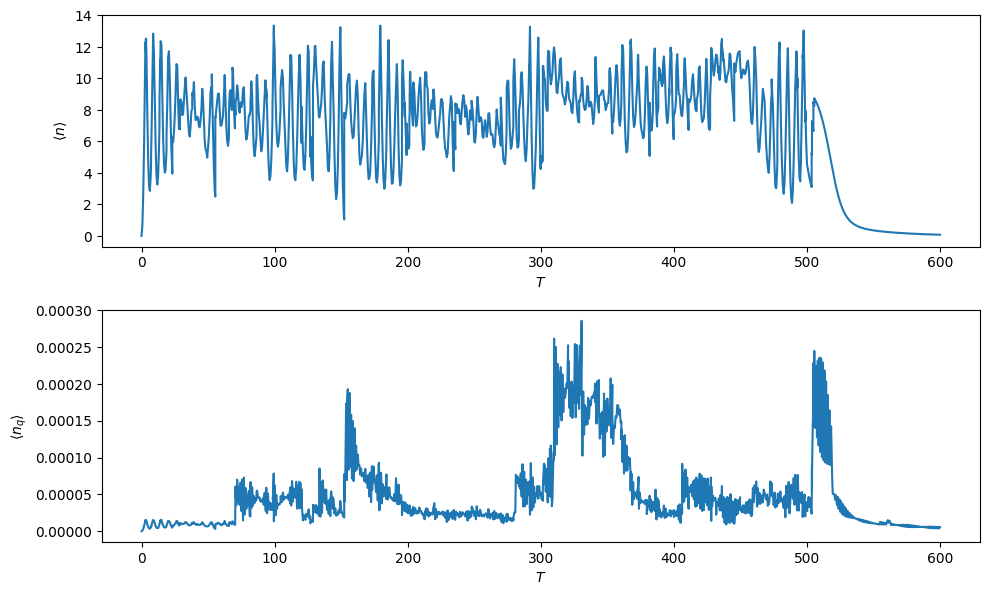

In [26]:
#exp_n_mcwf = exp_n_master #real(expect(n ⊗ one(b_spin), Ψt))
#exp_sz_mcwf = exp_sz_master #real(expect(one(b_fock) ⊗ sz, Ψt))

exp_n_mcwf = real(expect(n ⊗ one(b_spin), ρt))
exp_sz_mcwf = real(expect(one(b_fock) ⊗ (sp*sm), ρt));

figure(figsize=(10,6))
subplot(2,1,1)
#ylim([0, 2])
plot(tout, exp_n_mcwf)
xlabel(L"T")
ylabel(L"\langle n \rangle")

subplot(2,1,2)
#ylim([-1, 1])
plot(tout, exp_sz_mcwf)
xlabel(L"T")
ylabel(L"\langle n_{q} \rangle");

tight_layout();

For large number of trajectories the statistical average of the MCWF trajectories approaches the solution of the master equation.

In [30]:
Ntrajectories = 10
exp_n_average = zeros(Float64, length(T))
exp_sz_average = zeros(Float64, length(T))

for i = 1:Ntrajectories
    t_tmp, ψ = timeevolution.mcwf_dynamic(T, Ψ0, H_pump_open; rates=R,seed=i,
                                            maxiters=1e9)
    exp_n_average .+= real(expect(n ⊗ one(b_spin), ψ))
    exp_sz_average .+= real(expect(one(b_fock) ⊗ (sp*sm), ψ))
end

exp_n_average ./= Ntrajectories
exp_sz_average ./= Ntrajectories;

961-element Vector{Float64}:
 0.0
 1.2239307039890737e-6
 2.841038618811897e-6
 7.4062480058077585e-6
 1.1238484034749187e-5
 1.5992334819031396e-5
 1.4138745921130595e-5
 8.492296586365414e-6
 4.978521560947643e-6
 3.7074613808574224e-6
 2.7728734253479423e-6
 3.7640250122978087e-6
 5.695279690753448e-6
 ⋮
 0.00011285649424278925
 0.00012334688113766374
 0.00011568675483271406
 0.0001248591886832357
 0.00011877780782193618
 0.00012629682086095397
 0.00012210911329276782
 0.00012768742743012238
 0.0001256538417599143
 0.0001290656657217575
 0.0001293788422727278
 0.0001304713579062462

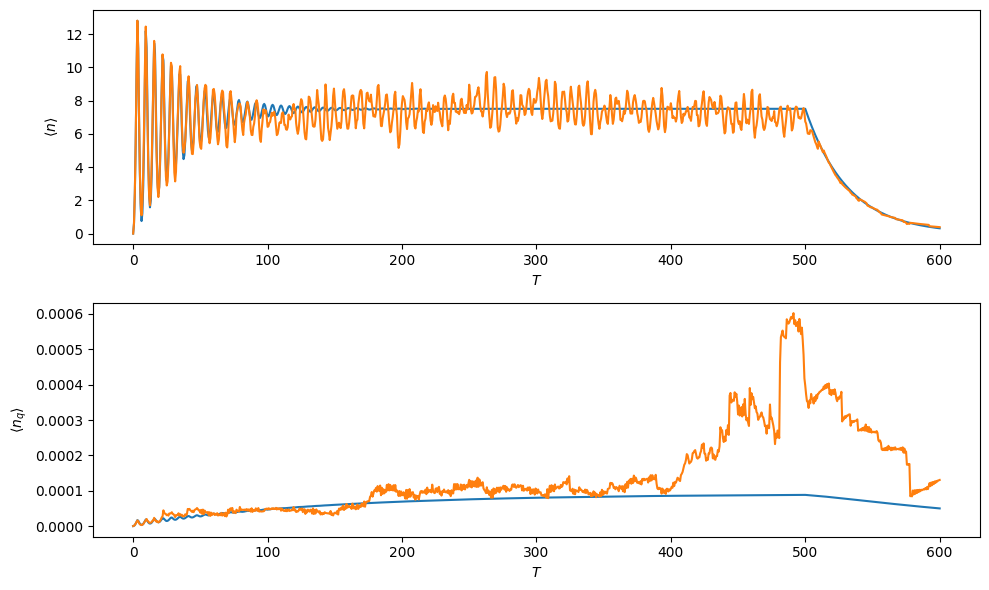

In [31]:
figure(figsize=(10,6))
subplot(2,1,1)
#ylim([0, 2])
plot(T, exp_n_master)
plot(T, exp_n_average)
xlabel(L"T")
ylabel(L"\langle n \rangle")

subplot(2,1,2)
#ylim([-1, 1])
plot(T, exp_sz_master)
plot(T, exp_sz_average)
xlabel(L"T")
ylabel(L"\langle n_q \rangle");

tight_layout()
show()